# Определяне на местоположение на лице в изображение

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import os
from sklearn.datasets import load_files
from PIL import Image
from collections import Counter
import pandas as pd
import cv2
from mtcnn import MTCNN


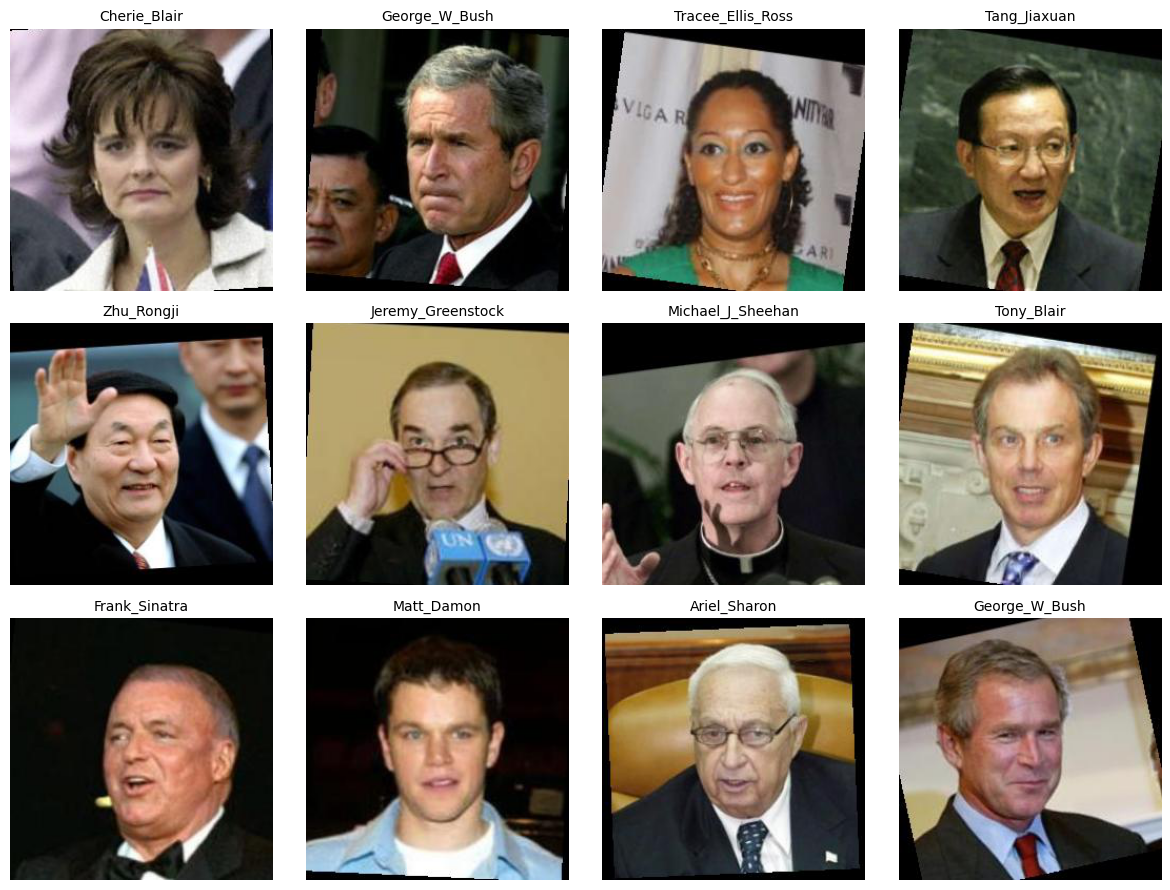

In [65]:
# Path to the dataset
dataset_path = "./archive/lfw_home/lfw-deepfunneled/lfw-deepfunneled"  # adjust this if needed

# Load dataset using sklearn's helper (it reads subfolders as class names)
data = load_files(dataset_path, load_content=False)
file_paths = np.array(data['filenames'])
targets = np.array(data['target'])
target_names = np.array(data['target_names'])

# Display 12 sample faces
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    img = Image.open(file_paths[i])
    ax.imshow(img)
    ax.set_title(target_names[targets[i]], fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

Dataset Summary:
- Total images: 13233
- Total people: 5749
- Avg images per person: 2.30
- Min images per person: 1
- Max images per person: 530
- Sample image sizes (from first 100):
  - Avg: (250.0, 250.0)
  - Min: (250, 250)
  - Max: (250, 250)


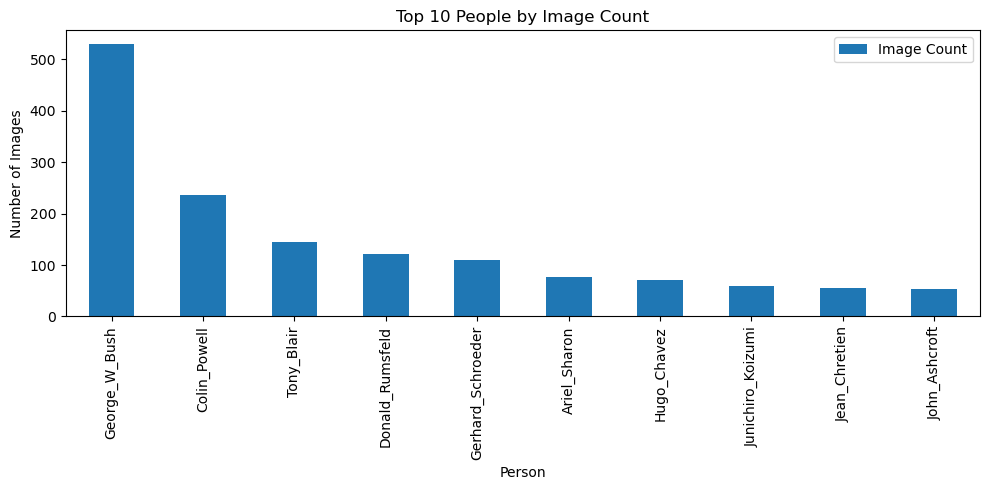

In [66]:
# Total number of images
num_images = len(file_paths)

# Number of unique people (classes)
num_classes = len(target_names)

# Count images per class
counts = Counter(targets)
img_counts = np.array(list(counts.values()))
img_per_person = pd.DataFrame({
    'Person': [target_names[i] for i in counts.keys()],
    'Image Count': img_counts
}).sort_values(by='Image Count', ascending=False)

# Get original image size statistics (just sample 100 to avoid loading everything)
original_sizes = []
for path in file_paths[:100]:
    try:
        img = Image.open(path)
        original_sizes.append(img.size)
    except:
        continue

widths, heights = zip(*original_sizes)
avg_size = (np.mean(widths), np.mean(heights))
min_size = (np.min(widths), np.min(heights))
max_size = (np.max(widths), np.max(heights))

# Display summary
print("Dataset Summary:")
print(f"- Total images: {num_images}")
print(f"- Total people: {num_classes}")
print(f"- Avg images per person: {np.mean(img_counts):.2f}")
print(f"- Min images per person: {np.min(img_counts)}")
print(f"- Max images per person: {np.max(img_counts)}")
print(f"- Sample image sizes (from first 100):")
print(f"  - Avg: {avg_size}")
print(f"  - Min: {min_size}")
print(f"  - Max: {max_size}")

# Plot top 10 people by image count
img_per_person.head(10).plot.bar(x='Person', y='Image Count', figsize=(10, 5), title='Top 10 People by Image Count')
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [67]:
# Preprocessing settings
IMAGE_SIZE = (128, 128)
processed_images = []
original_images = []

for path in file_paths[:100]:  # Limit for speed (adjust if needed)
    try:
        img = Image.open(path)
        original_images.append(np.array(img))       # Keep original for later face detection
        img = img.resize(IMAGE_SIZE)                # Resize
        img = np.asarray(img, dtype=np.float32) / 255.0  # Normalize
        processed_images.append(img)
    except Exception as e:
        print(f"Error processing {path}: {e}")

processed_images = np.array(processed_images)
print("Processed images shape:", processed_images.shape)

Processed images shape: (100, 128, 128, 3)


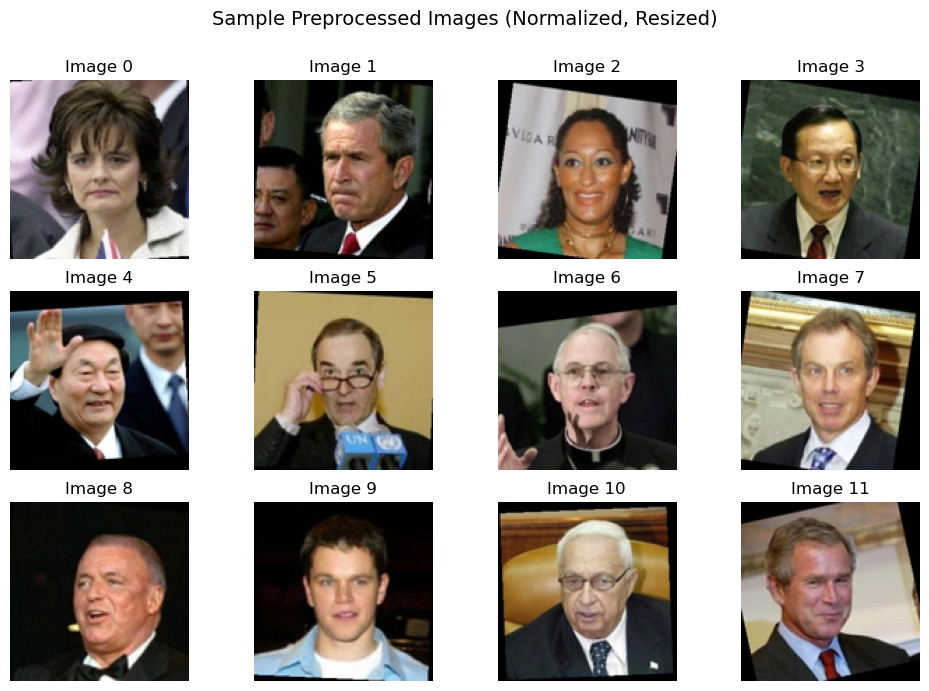

In [68]:
# Show a few preprocessed images
num_images_to_show = 12
fig, axes = plt.subplots(3, 4, figsize=(10, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(processed_images[i])
    ax.set_title(f"Image {i}")
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Preprocessed Images (Normalized, Resized)", fontsize=14)
plt.subplots_adjust(top=0.88)
plt.show()

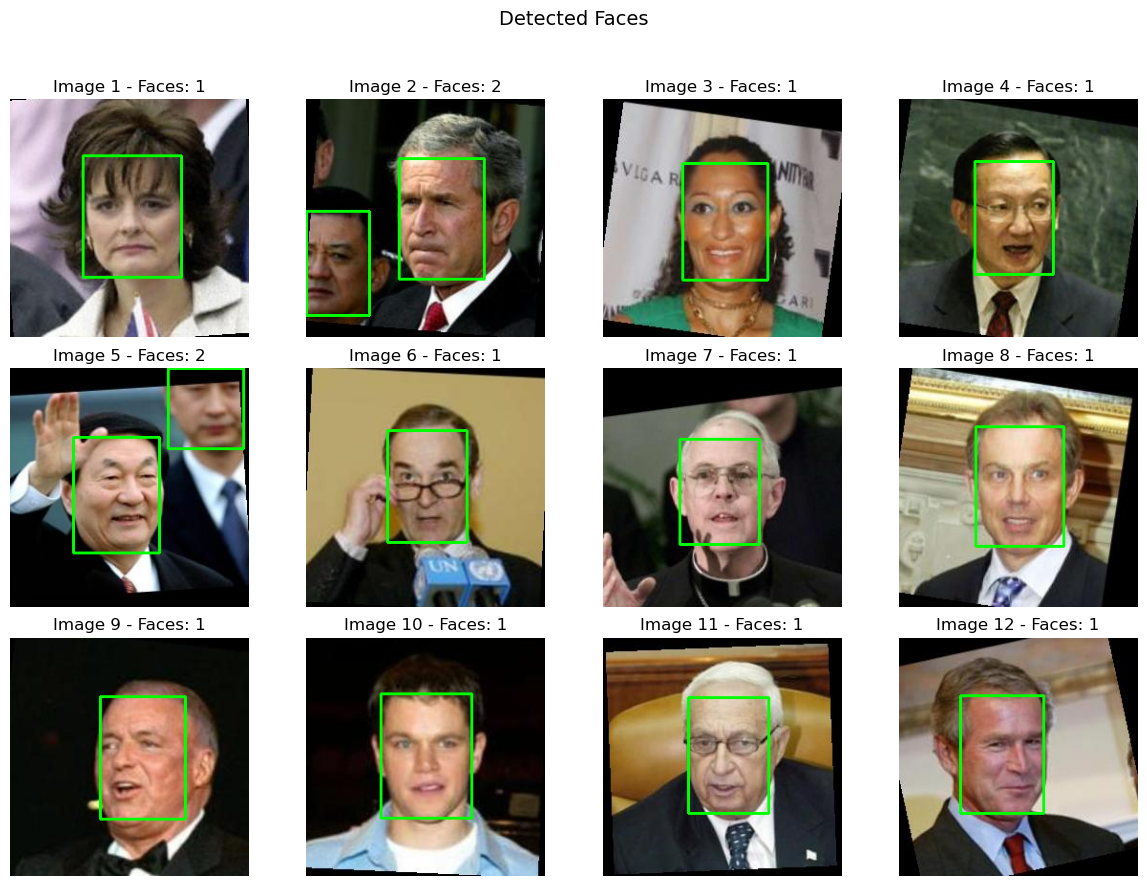

In [71]:
# Initialize MTCNN detector
detector = MTCNN()

def detect_faces_mtcnn(image_path):
    """ Detect multiple faces using MTCNN """
    
    img = cv2.imread(image_path)  # Load the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN

    # Detect faces using MTCNN
    faces = detector.detect_faces(img_rgb)

    # Draw bounding boxes around detected faces
    for face in faces:
        x, y, w, h = face['box']
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert image back to RGB for correct display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img_rgb, len(faces)  # Return image and number of faces detected


num_images_to_display = 12

# Create a 3x4 grid for displaying images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Loop over the image paths and display them on the axes grid
for i, (path, ax) in enumerate(zip(file_paths[:num_images_to_display], axes.flat)):
    img_rgb, face_count = detect_faces_mtcnn(path)
    
    # Display the image
    ax.imshow(img_rgb)
    
    # Set the title to include the number of faces found
    ax.set_title(f"Image {i+1} - Faces: {face_count}")
    
    # Hide the axes
    ax.axis('off')

# Adjust layout and show the final plot
plt.tight_layout()
plt.suptitle("Detected Faces", fontsize=14)
plt.subplots_adjust(top=0.88)
plt.show()

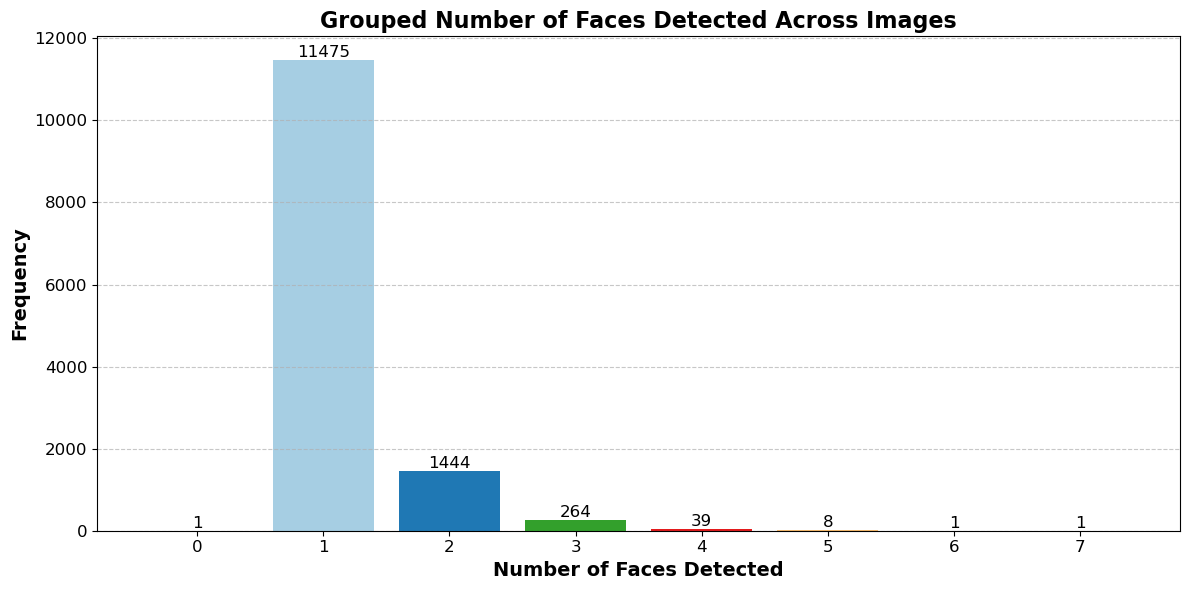

In [72]:
# Assuming face_counts is already populated with the number of faces detected in each image
face_counts = []

for i, path in enumerate(file_paths):
    img_rgb, face_count = detect_faces_mtcnn(path)
    face_counts.append(face_count)

# Count the occurrences of each unique face count
face_count_freq = Counter(face_counts)

# Get the unique face counts and their corresponding frequencies
unique_face_counts = list(face_count_freq.keys())
frequencies = list(face_count_freq.values())

# Enhance the bar chart visualization
plt.figure(figsize=(12, 6))

# Use a color palette for the bars
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_face_counts)))

# Plot the bar chart with color
bars = plt.bar(unique_face_counts, frequencies, color=colors)

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, str(int(yval)), ha='center', va='bottom', fontsize=12)

# Set axis labels, title, and other customizations
plt.xlabel("Number of Faces Detected", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Grouped Number of Faces Detected Across Images", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines to make the chart easier to read
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  # Adjust the layout to ensure everything fits well
plt.show()